# PRML 2.5 ノンパラメトリック法

社内PRML勉強会 担当@hagino3000

## ヒストグラム密度推定法

$\displaystyle
pi = \frac{n_{i}}{N\Delta i}$

In [99]:
from __future__ import division
import scipy.stats

In [131]:
# 図2.24を再現するための確率分布 (混合正規分布)
GAUSSIAN_1_MEAN = 0.28
GAUSSIAN_1_STD = 0.08
GAUSSIAN_2_MEAN = 0.77
GAUSSIAN_2_STD = 0.10

def multinormal_rand(n):
    ret = []
    for _ in xrange(n):
        if np.random.rand() <= 0.25:
            ret.append(np.random.normal(GAUSSIAN_1_MEAN, GAUSSIAN_1_STD))
        else:
            ret.append(np.random.normal(GAUSSIAN_2_MEAN, GAUSSIAN_2_STD))
    return np.array(ret)

def multinormal_pdf(x):
    return (0.25 * scipy.stats.norm.pdf(x, GAUSSIAN_1_MEAN, GAUSSIAN_1_STD) + 
            0.75 * scipy.stats.norm.pdf(x, GAUSSIAN_2_MEAN, GAUSSIAN_2_STD))

multinormal_pdf = np.vectorize(multinormal_pdf)

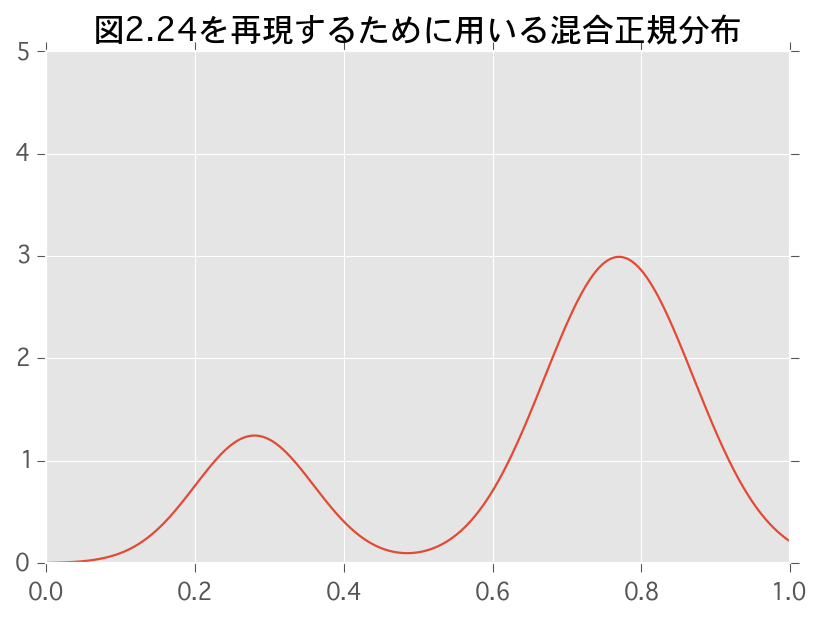

In [407]:
def plot_pdf():
    X = np.linspace(0, 1, 1000)
    Y = multinormal_pdf(X)
    plt.plot(X, Y)
    plt.ylim(0, 5)
    plt.xlim(0, 1)
    
plot_pdf()
plt.title(u'図2.24を再現するために用いる混合正規分布')

In [408]:
N = 50
Xn = multinormal_rand(N)

(array([  5.,   3.,   2.,   0.,   1.,   5.,  13.,  13.,   6.,   2.]),
 array([ 0.1993735 ,  0.28256491,  0.36575632,  0.44894773,  0.53213914,
         0.61533055,  0.69852196,  0.78171337,  0.86490478,  0.94809619,
         1.0312876 ]),
 <a list of 10 Patch objects>)

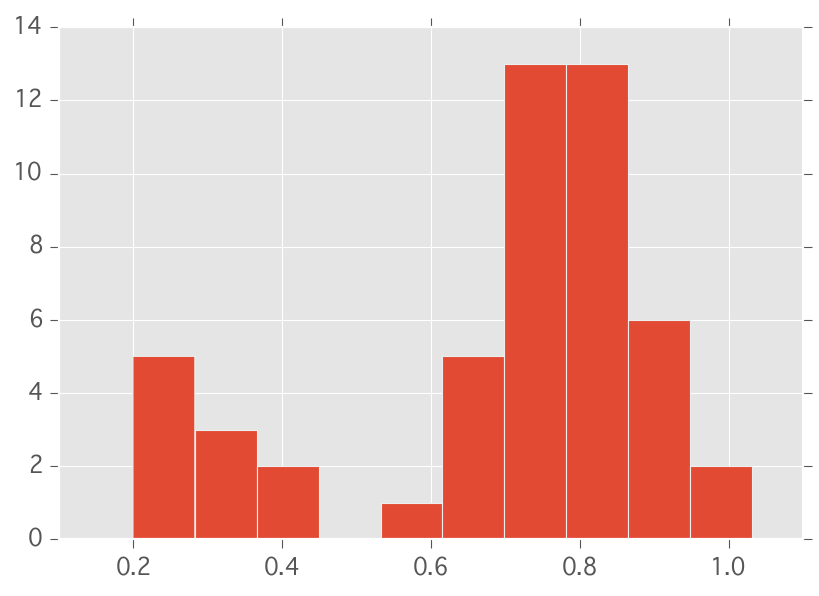

In [409]:
plt.hist(Xn)

In [410]:
def plot_histogram_density_estimation_method(X, N, delta=0.04):
    hist, bins = np.histogram(X, bins=np.arange(0, 1+delta, delta))
    # pi = ni/NDeltai
    hist = hist/(N*delta)
    plt.bar(bins[:-1], hist, width=delta)
    plt.title('$\Delta = %f$' % delta)

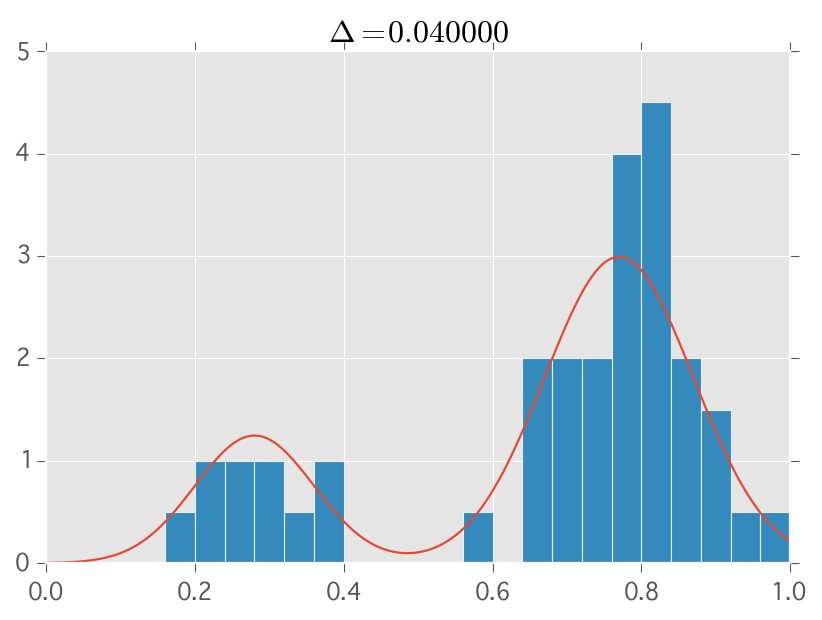

In [411]:
plot_histogram_density_estimation_method(Xn, N, delta=0.04)
plot_pdf()

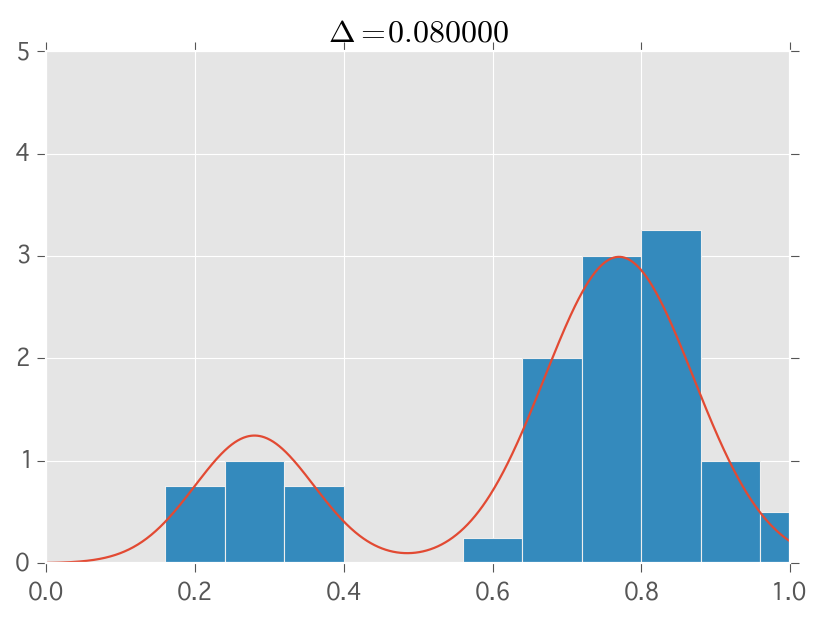

In [412]:
plot_histogram_density_estimation_method(Xn, N, delta=0.08)
plot_pdf()

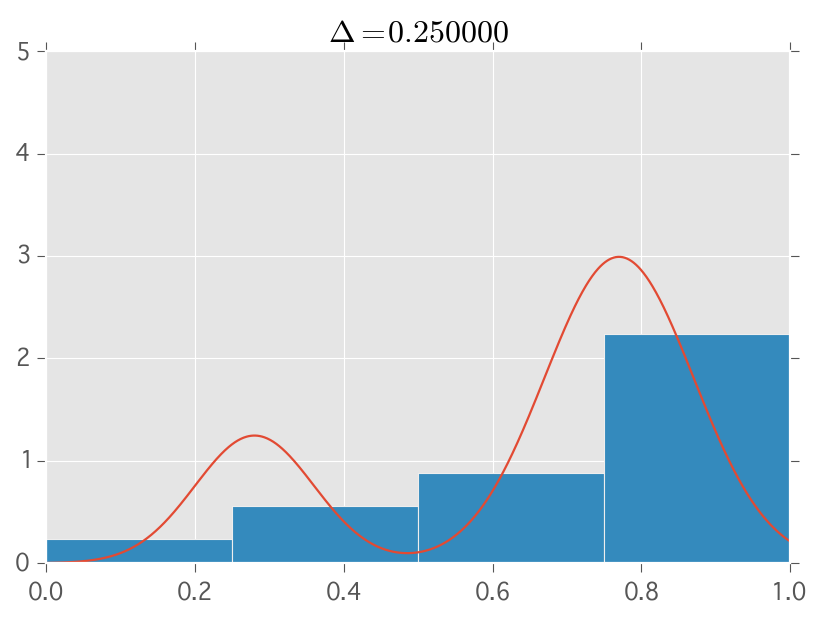

In [413]:
plot_histogram_density_estimation_method(Xn, N, delta=0.25)
plot_pdf()

$\Delta$は大きすぎても小さすぎてもデータの特徴を捉えられない

- Good
  - 一旦ヒストグラムを求めてしまえば、元のデータ集合自体は破棄できる
  - ヒストグラムによるアプローチは、データ点が逐次的にあたえられても、容易に適用できる
- Bad
  - 推定した密度が区間の縁で不連続になる
  - 次元数の増加に共なう計算規模の増大 (次元の呪い)

## 2.5.1 カーネル密度推定法



ある$D$次元のユークリッド空間中の未知の確率密度 $p(\bf{x})$ から、観測値の集合が得られていて、この集合から $p(\bf{x})$ の値を推定したいとする。ここで $\bf{x}$ を含むある小さな領域 $R$ を考える。この領域に割りあてられた確率は

$P = \int_{R}{p(x)dx}$ (2.242)

$p(\bf{x})$から得られた$N$個の観測値からなるデータ集合をあつめたとする。各データ点が$R$中にある確率は$P$なので、$R$内の点の総数$K$は、二項分布に従う。

$\displaystyle
Bin(K|N,P) = \frac{N!}{K!(N - K)!}P^K(1 - P)^{N-K}$ (2.243)

----
[復習]  
二項分布  
観測値$x \in [0, 1]$が$N$個あり、それぞれ$x=1$となる確率が$\mu$の場合に、$x=1$が$m$回出る時の確率分布

$Bin(m|N,\mu) = \binom{N}{m}\mu^m(1 - \mu)^{N-m}$

$\displaystyle
\binom{N}{m} \equiv \frac{N!}{(N-M)!m!}$

---

二項分布の平均の式 (2.11) より、点がこの領域内にある平均個数は$NP$、

点がこの領域内にある平均割合は $E[K/N] = P$  
平均の周りの分散は $var[K/N] = P(1-P)/N$ となる。よって大きなNについて、この分布は平均の周囲で鋭く尖ったものとなり

$K \simeq NP$ (2.244)

しかし、$R$が、確率密度が $p(x)$ がこの領域内でほぼ一定とみなせるほど十分に小さいとも仮定できるのであれば

$P \simeq p(x)V$ (2.245)

が成り立つ

(2.244)と(2.245)から $p(x) = \frac{K}{NV}$ (2.246)

## カーネルとしてParzen窓を使った場合

カーネル関数の一例、単位立方体を表す

$k((x - x_{n})/h)$ は、xを中心とする一辺がhの立方体の内部にデータ点$x_{n}$があれば1、そうでなければ0。この立方体内部の総点数は

$\displaystyle
K = \sum_{n=1}^{N}k(\frac{x - x_n}{h})$ (2.248)

この$K$を (2.246) に代入すると

$\displaystyle
p(x) = \frac{1}{N}\sum_{n=1}^{N}\frac{1}{h^D}k(\frac{x-x_n}{h})$

In [295]:
def parzen(x):
    return 1 if np.abs(x) <= 1/2 else 0

parzen = np.vectorize(parzen)

def kernel_density_parzen(X, x, h):
    return 1/len(X) * np.sum(parzen((X - x)/h)/h)

In [320]:
N = 50
Xn = multinormal_rand(N)

def plot_kernel_density_parzen(h=0.005):
    X = np.linspace(0, 1, 200)
    ret = []
    for x in X:
        ret.append(kernel_density_parzen(Xn, x, h))
    plt.plot(X, ret)
    plt.title('h=%f' % h)

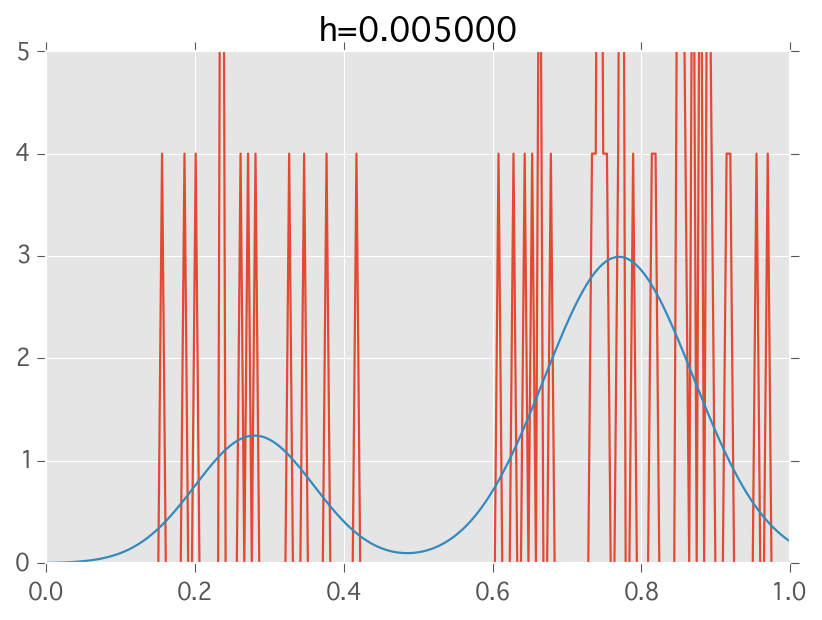

In [393]:
plot_kernel_density_parzen(0.005)
plot_pdf()

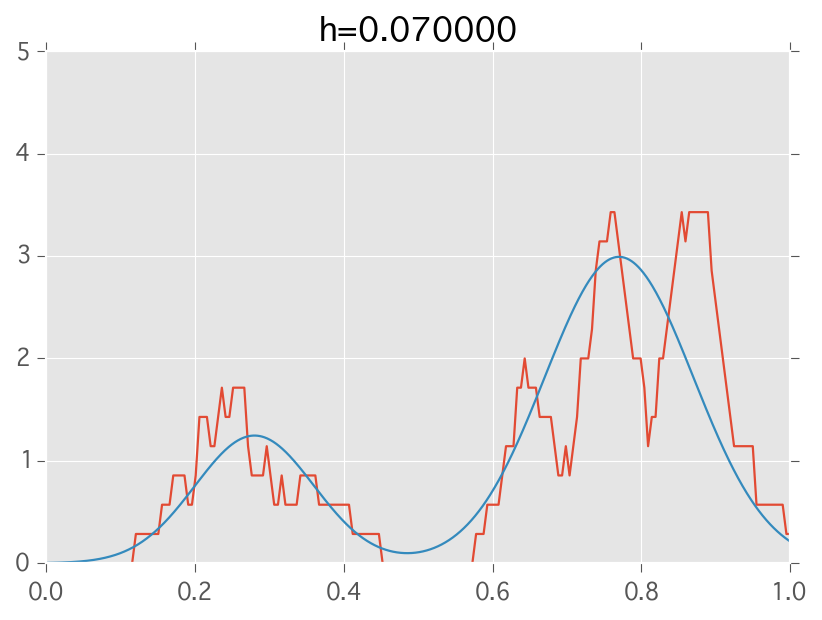

In [394]:
plot_kernel_density_parzen(0.07)
plot_pdf()

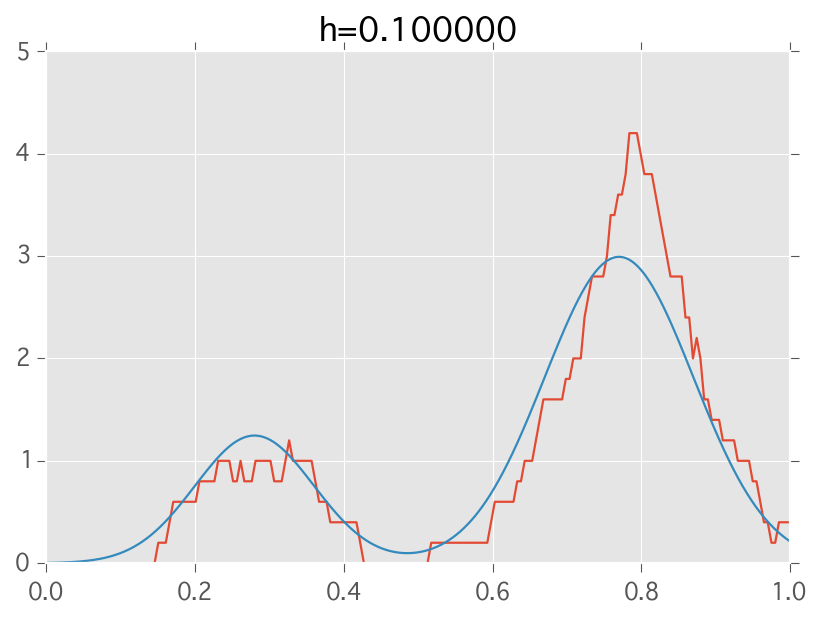

In [415]:
plot_kernel_density_parzen(0.1)
plot_pdf()

より滑らかな密度モデルとしてガウスカーネルを使った場合

$\displaystyle
p(x) = \frac{1}{N}\sum_{n=1}^{N}\frac{1}{(2\pi h^2)^{D/2}}exp\{-\frac{||x-x_n||^2}{2h^2}\}$

In [404]:
def kernel_density_gaussian(X, x, h):
    # 1次元データに限定した実装 (ユークリッド空間中の1次元データ同士の距離をnp.absを使って出している)
    return 1/len(X) * np.sum(1/np.sqrt((2*np.pi*h**2)) * np.exp(-1 * np.abs(X - x)**2/(2*h**2)))

In [397]:
def plot_kernel_density_gaussian(h=0.005):
    X = np.linspace(0, 1, 200)
    ret = []
    for x in X:
        ret.append(kernel_density_gaussian(Xn, x, h))
    plt.plot(X, ret)
    plt.title('h=%f' % h)

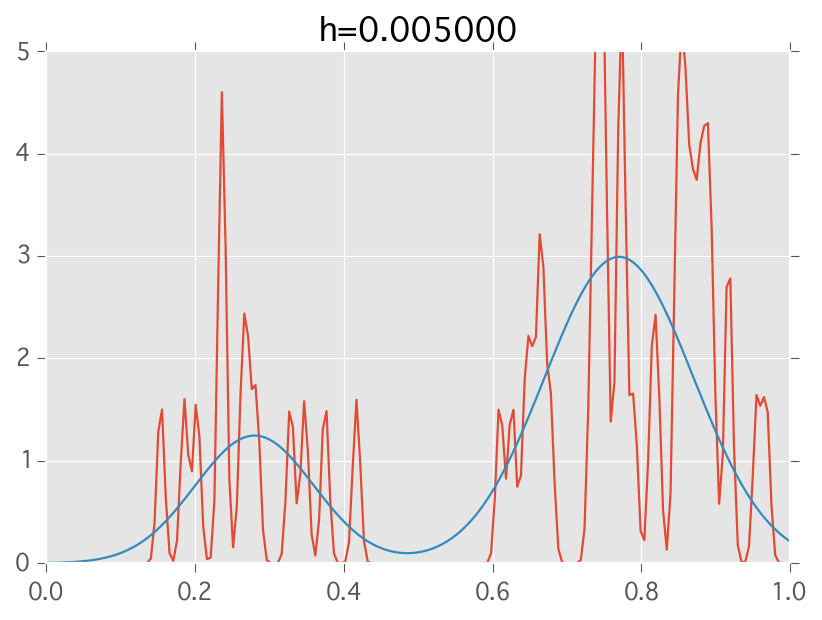

In [398]:
plot_kernel_density_gaussian()
plot_pdf()

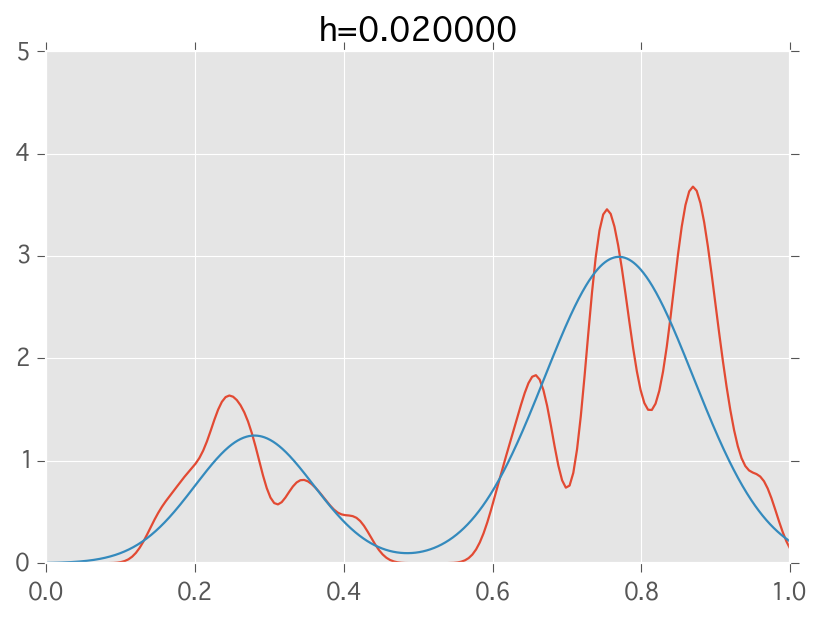

In [399]:
plot_kernel_density_gaussian(0.02)
plot_pdf()

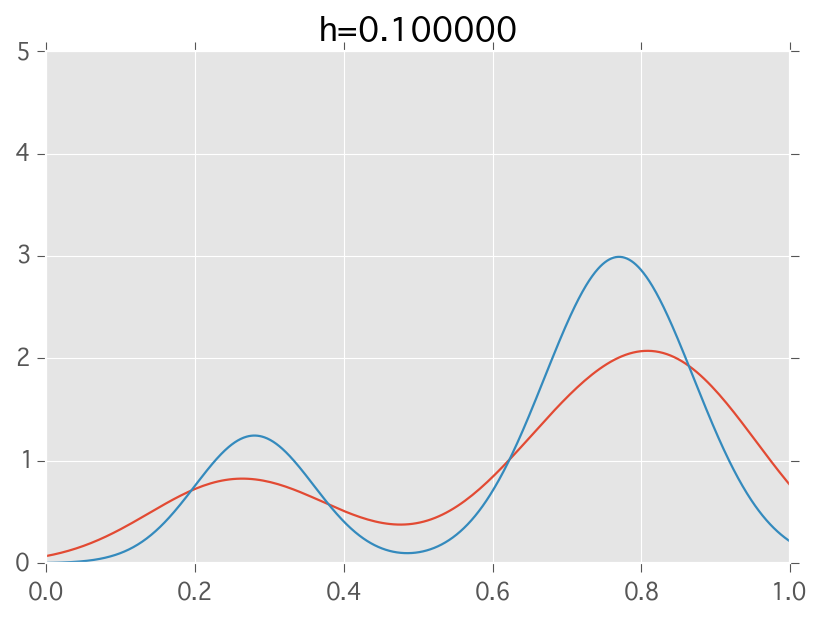

In [400]:
plot_kernel_density_gaussian(0.1)
plot_pdf()

hは平滑化パラメータの役割を果たすのがわかる。画像処理のガウシアンフィルタもこれ、式を見ると重そうだけど並列処理ができるのでGPUを使えば良い。